# Table Length Measurements

Python program for analysing measurements of the length of the lecture table in Auditorium A at NBI.  
There are two measurements each with estimated error of the table length:
1. Measurement with a 30cm ruler.
2. Measurement with a 2m folding ruler.

Each person was asked not only to state the measurement, but also their (gu)estimated uncertainty. None of the persons could see others measurements in order to get the largest degree of independence. Also, the 30cm ruler measurement was asked to be done first. Finally, those measuring were asked to try to measure to the mm, even if precision was less than this, and not to correct any measurement once written down.

### Authors: 
- Troels C. Petersen (Niels Bohr Institute)

### Date:    
- 25-11-2021 (latest update)

***

In [13]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys
from scipy import stats
from scipy.special import erfc                         # Error function, to get integral of Gaussian
import pandas as pd

sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

### Reading submitted solutions:

In [14]:
data = pd.read_csv("StudentResults2021_TableMeasurement.csv")
data.keys()

Index(['Timestamp', 'Name:', '30cm ruler, unweighted - mean (m):',
       '30cm ruler, unweighted - uncertainty (m):',
       '30cm ruler, unweighted - Number of measurements used:',
       '30cm ruler, weighted - mean (m):',
       '30cm ruler, weighted - uncertainty (m):',
       '30cm ruler, weighted - Number of measurements used:',
       '30cm ruler vs. 2m folding rule, unweighted - difference in terms of uncertainty (number of sigmas):',
       '30cm ruler vs. 2m folding rule, weighted - difference in terms of uncertainty (number of sigmas):'],
      dtype='object')

### Length Estimate:

Hist_Luw  = TH1F("Hist_Luw",  ";Unweighted mean;Frequency", 100, 3.3, 3.4); \
Hist_eLuw = TH1F("Hist_eLuw", ";Uncertainty on unweighted mean;Frequency", 1000, 0.0, 0.2); \
Hist_Nuw  = TH1F("Hist_Nuw",  ";Number of measurements used in unweighted mean;Frequency", 60, -0.5, 299.5); \
Hist_Lw   = TH1F("Hist_Lw",   ";Weighted mean;Frequency", 100, 3.3, 3.4); \
Hist_eLw  = TH1F("Hist_eLw",  ";Uncertainty on weighted mean;Frequency", 1000, 0.0, 0.2); \
Hist_Nw   = TH1F("Hist_Nw",   ";Number of measurements used in weighted mean;Frequency",   60, -0.5, 299.5); \
Hist_dL   = TH1F("Hist_dL",   ";Difference in length measurements (Luw - Lw);Frequency",  201,   -0.05, 0.05); \
Hist_feL  = TH1F("Hist_feL",  ";Ratio of length uncertainties (eLuw / eLw);Frequency",    200,    0.0,  10.0); \
Hist_dN   = TH1F("Hist_dN",   ";Difference in number of measurements used;Frequency",     201, -100.5, 100.5); \

In [15]:
L30cm = np.array(data['30cm ruler, unweighted - mean (m):'], dtype=float)
L30cm

array([3.36193   , 3.35893   , 3.3606    , 3.411     , 3.41      ,
       3.362     , 3.358     , 3.327     , 3.376     , 3.376     ,
       3.376     , 3.41      , 3.36      , 3.361     , 3.41148   ,
       3.37625498, 3.405     , 3.41      , 3.36129   , 3.376     ,
       3.36190557, 3.3365    , 3.3618    , 3.3617    , 3.376     ,
       3.36      , 3.36199   , 3.365     , 3.407     , 3.362     ,
       3.411     , 3.412     , 3.412     , 3.376     , 3.41      ,
       3.344     , 3.361     , 3.361     ])

In [29]:
print(np.std(L30cm)/np.sqrt(len(L30cm)))

0.0038568617212876954


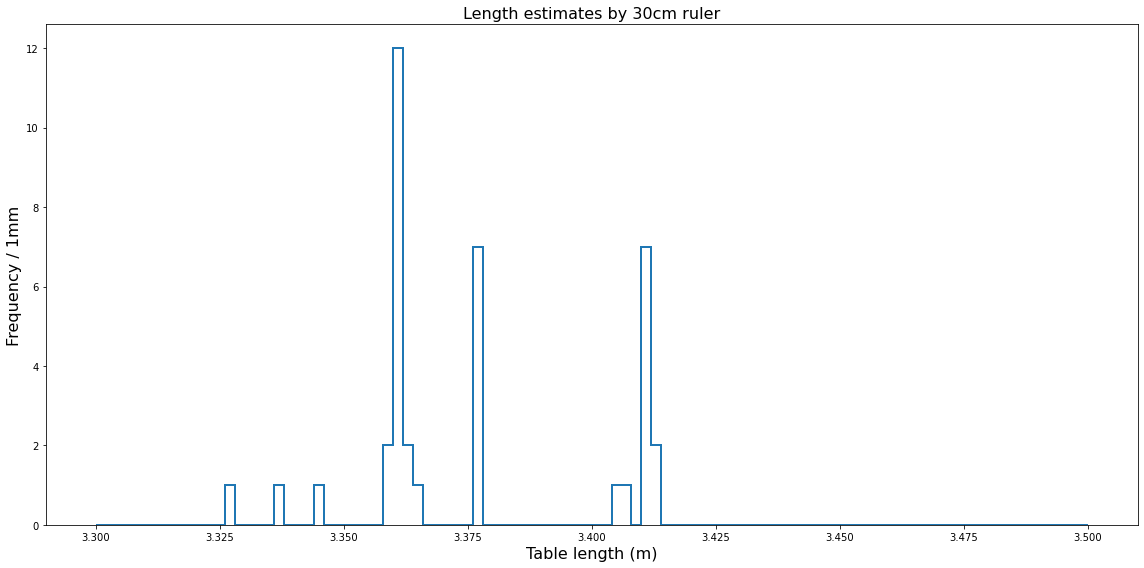

In [16]:
Nbins = 100
minL = 3.3
maxL = 3.5

# Define two histograms with all the lengths recorded:
fig_L30cm, ax_L30cm = plt.subplots(figsize=(16,8))
hist_L30cm = ax_L30cm.hist(L30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_L30cm.set_title('Length estimates by 30cm ruler', fontsize=16)
ax_L30cm.set_ylabel('Frequency / 1mm', fontsize=16)
ax_L30cm.set_xlabel('Table length (m)', fontsize=16)

fig_L30cm.tight_layout()
fig_L30cm.savefig("Dist_L30cm.pdf")

In [17]:
eL30cm = np.array(data['30cm ruler, unweighted - uncertainty (m):'], dtype=float)
eL30cm

array([0.00164   , 0.00082   , 0.0008    , 0.001     , 0.01      ,
       0.0004    , 0.001     , 0.215     , 0.046     , 0.008     ,
       0.008     , 0.001     , 0.001     , 0.001     , 0.01082   ,
       0.06063376, 0.001     , 0.05      , 0.00048   , 0.008     ,
       0.00033552, 0.0056    , 0.0004    , 0.0004    , 0.215     ,
       0.16      , 0.00044   , 0.008     , 0.002     , 0.00045   ,
       0.009     , 0.008     , 0.008     , 0.008     , 0.026     ,
       0.115     , 0.001     , 0.001     ])

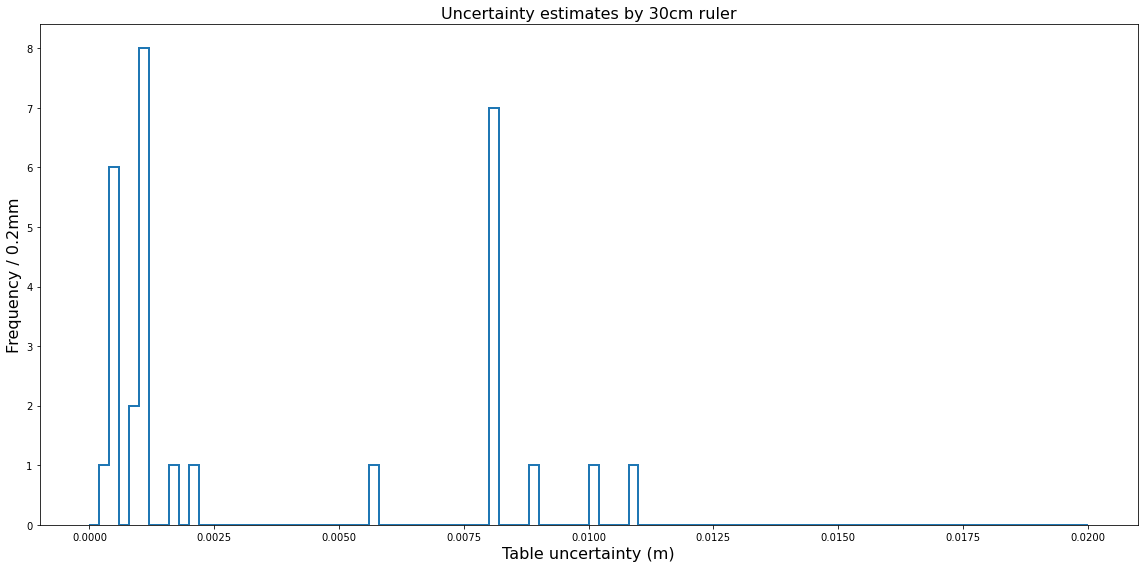

In [18]:
Nbins = 100
minL = 0.0
maxL = 0.02

# Define two histograms with all the lengths recorded:
fig_eL30cm, ax_eL30cm = plt.subplots(figsize=(16,8))
hist_eL30cm = ax_eL30cm.hist(eL30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_eL30cm.set_title('Uncertainty estimates by 30cm ruler', fontsize=16)
ax_eL30cm.set_ylabel('Frequency / 0.2mm', fontsize=16)
ax_eL30cm.set_xlabel('Table uncertainty (m)', fontsize=16)

fig_eL30cm.tight_layout()
fig_eL30cm.savefig("Dist_eL30cm.pdf")

In [19]:
N30cm = np.array(data['30cm ruler, unweighted - Number of measurements used:'], dtype=float)
N30cm

array([552., 622., 654., 651., 568., 518., 733., 785., 626., 785., 785.,
       630., 665., 640., 567., 785., 588., 662., 665., 785., 592., 770.,
       648., 625., 785., 518., 538., 785., 785., 568., 517., 518., 518.,
       785., 640., 758., 765., 768.])

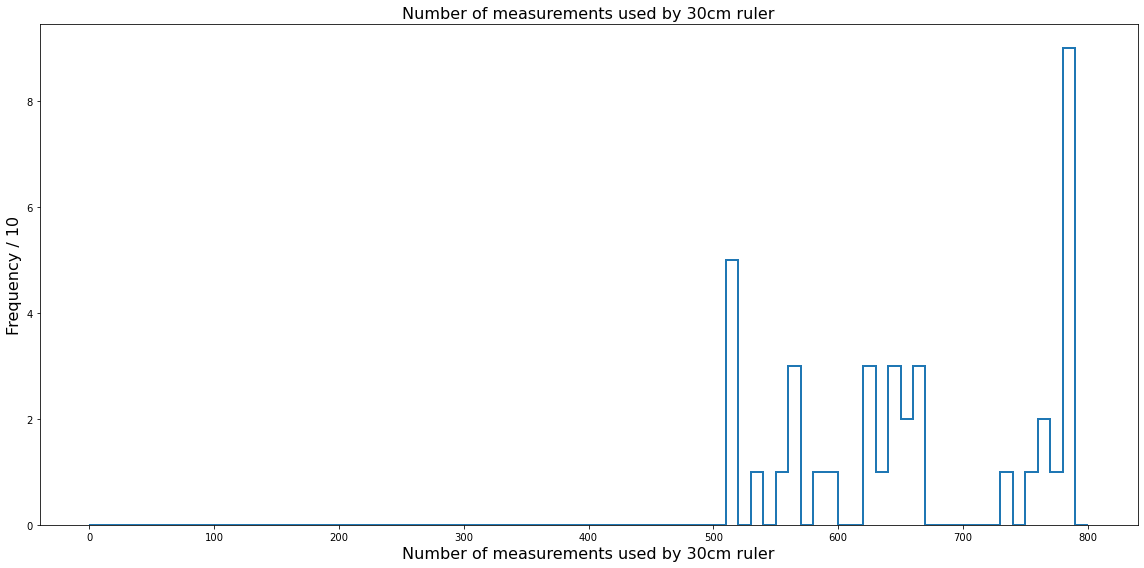

In [20]:
Nbins = 80
minL = 0.0
maxL = 800.0

# Define two histograms with all the lengths recorded:
fig_N30cm, ax_N30cm = plt.subplots(figsize=(16,8))
hist_N30cm = ax_N30cm.hist(N30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_N30cm.set_title('Number of measurements used by 30cm ruler', fontsize=16)
ax_N30cm.set_ylabel('Frequency / 10', fontsize=16)
ax_N30cm.set_xlabel('Number of measurements used by 30cm ruler', fontsize=16)

fig_N30cm.tight_layout()
fig_N30cm.savefig("Dist_N30cm.pdf")

In [30]:
wL30cm = np.array(data['30cm ruler, weighted - mean (m):'], dtype=float)
wL30cm

array([3.36646   , 3.34808   , 3.3524    , 3.279     , 3.394     ,
       3.364     , 3.39775   , 3.36      , 3.41      , 3.398     ,
       3.41      , 3.4       , 3.38      , 3.338     , 3.41231   ,
       3.38593307, 3.406     , 3.41      , 3.36118   , 3.386     ,
       3.36185379, 3.2791    , 3.3622    , 3.3622    , 3.411     ,
       3.4149    , 3.33618   , 3.376     , 3.4122    , 3.364     ,
       3.415     , 3.4149    , 3.4149    , 3.339     , 3.38      ,
       3.362     , 3.367     , 3.3607    ])

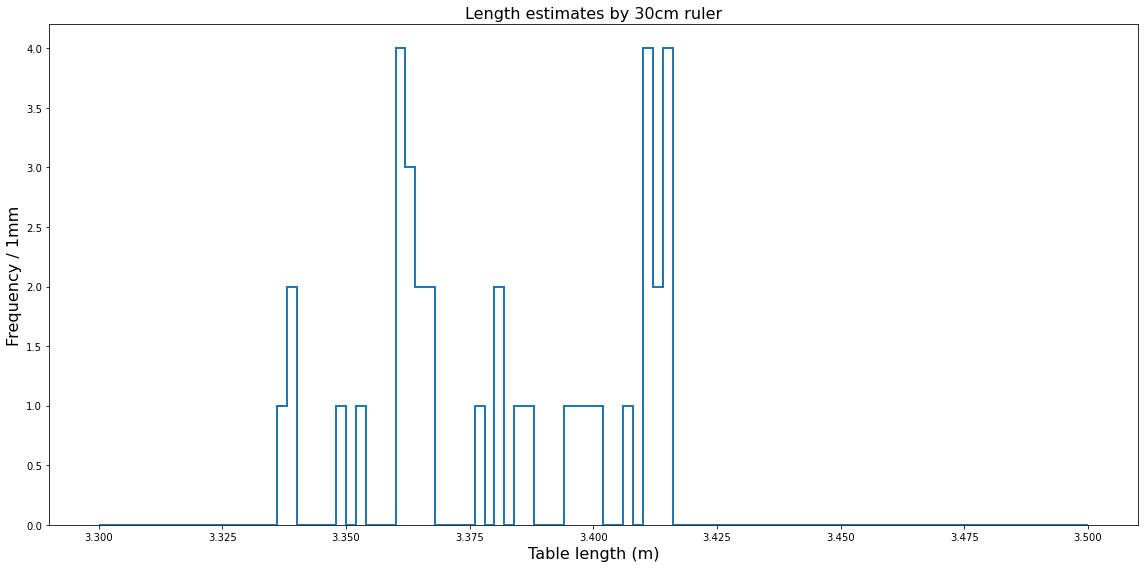

In [31]:
Nbins = 100
minL = 3.3
maxL = 3.5

# Define two histograms with all the lengths recorded:
fig_wL30cm, ax_wL30cm = plt.subplots(figsize=(16,8))
hist_wL30cm = ax_wL30cm.hist(wL30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_wL30cm.set_title('Length estimates by 30cm ruler', fontsize=16)
ax_wL30cm.set_ylabel('Frequency / 1mm', fontsize=16)
ax_wL30cm.set_xlabel('Table length (m)', fontsize=16)

fig_wL30cm.tight_layout()
fig_wL30cm.savefig("Dist_wL30cm.pdf")

In [32]:
ewL30cm = np.array(data['30cm ruler, weighted - uncertainty (m):'], dtype=float)
ewL30cm

array([2.20000000e-04, 1.90000000e-04, 3.00000000e-04, 4.00000000e-02,
       7.00000000e-03, 2.00000000e-04, 1.90000000e-04, 2.00000000e-02,
       1.20000000e-02, 6.80000000e-02, 1.00000000e-03, 2.00000000e-04,
       2.00000000e-04, 2.10000000e-04, 1.15600000e-02, 1.89128663e-04,
       1.00000000e-03, 1.00000000e-02, 5.03000000e-03, 1.00000000e-03,
       2.04830782e-04, 4.10000000e-03, 6.59000000e-02, 8.80000000e-03,
       1.30000000e-02, 9.00000000e-03, 1.90000000e-04, 5.00000000e-03,
       5.00000000e-04, 1.00000000e-05, 2.00000000e-04, 2.00000000e-04,
       2.00000000e-04, 2.00000000e-03, 4.80000000e-02, 1.13000000e-01,
       2.00000000e-04, 1.00000000e-04])

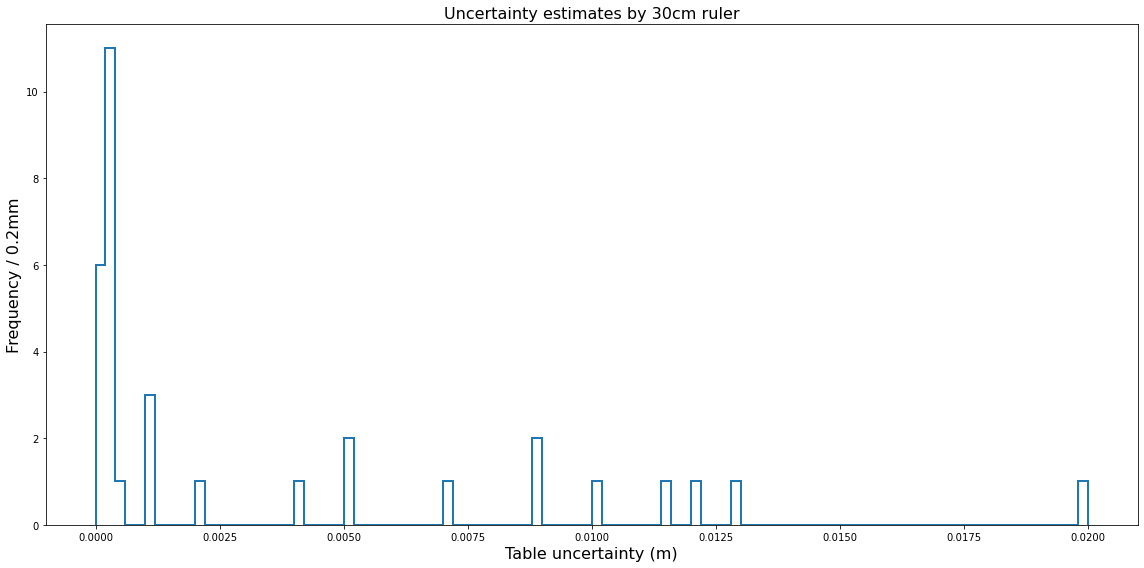

In [33]:
Nbins = 100
minL = 0.0
maxL = 0.02

# Define two histograms with all the lengths recorded:
fig_ewL30cm, ax_ewL30cm = plt.subplots(figsize=(16,8))
hist_ewL30cm = ax_ewL30cm.hist(ewL30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_ewL30cm.set_title('Uncertainty estimates by 30cm ruler', fontsize=16)
ax_ewL30cm.set_ylabel('Frequency / 0.2mm', fontsize=16)
ax_ewL30cm.set_xlabel('Table uncertainty (m)', fontsize=16)

fig_ewL30cm.tight_layout()
fig_ewL30cm.savefig("Dist_ewL30cm.pdf")

In [25]:
Nw30cm = np.array(data['30cm ruler, weighted - Number of measurements used:'], dtype=float)
Nw30cm

array([552., 785., 654., 651., 568., 518., 785., 732., 576., 758., 630.,
       630., 739., 739., 574., 785., 575., 662., 665., 453., 592., 750.,
       648., 625., 590., 518., 538., 785., 662., 568., 517., 518., 518.,
       763., 640., 753., 765., 765.])

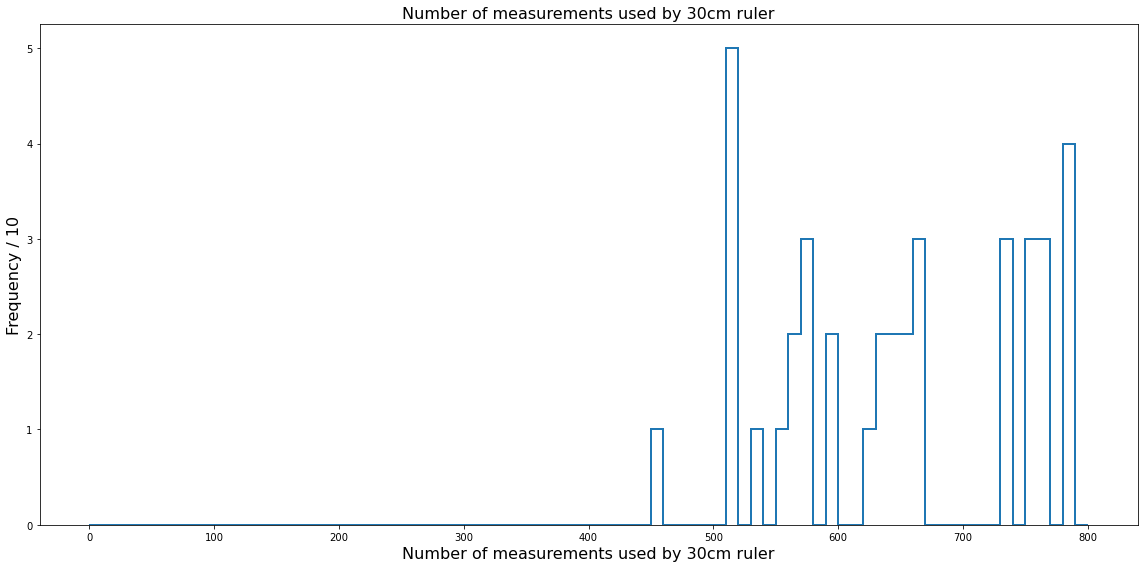

In [34]:
Nbins = 80
minL = 0.0
maxL = 800.0

# Define two histograms with all the lengths recorded:
fig_Nw30cm, ax_Nw30cm = plt.subplots(figsize=(16,8))
hist_Nw30cm = ax_Nw30cm.hist(Nw30cm, bins=Nbins, range=(minL, maxL), histtype='step', lw=2, label='30cm data')
ax_Nw30cm.set_title('Number of measurements used by 30cm ruler', fontsize=16)
ax_Nw30cm.set_ylabel('Frequency / 10', fontsize=16)
ax_Nw30cm.set_xlabel('Number of measurements used by 30cm ruler', fontsize=16)

fig_Nw30cm.tight_layout()
fig_Nw30cm.savefig("Dist_Nw30cm.pdf")